## 自编程实现KNN线性扫描算法
>问题描述： 给定一个二维空间的数据集T={正实例：(5,4), (9,6), (4,7)}; 负实例：{(2,3), (8,1), (7,2)}， 基于欧氏距离，找到数据点S（5,3）的最近邻（k=1）， 并对S点进行分类预测<br>
下面自编程实现KNN线性扫描算法，从最简单的暴力算法开始，然后提出存在的问题并进行改进<br>
>>附加： 改进的线性扫描算法和Kd树<br>
>
>
PS: 线性扫描算法与kd树算法的时间复杂度
>> 只考虑样本数N的影响：<br>线性扫描： 计算N个距离 O(N) <br> kd tree： 二叉树搜索 O(log2N) <br> 实际上当维度d接近N时， 二者效率相当
>
>关于kd树算法的推导过程，见k近邻笔记<br>
>
>基于对象编程，学习Python对象编程知识，并介绍几个好用的Python模块

## 1. 导入用到的包

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import heapq         # 该模块提供了推排序算法的实现，用于改进的线性扫描算法
import time        # 时间模块，计算时间

# 这两个来自于collections模块
from collections import namedtuple      # 生成可以使用名字来访问元素内容的tuple子类， 用于kd树
from collections import Counter     # 计数器，主要用来计数

from concurrent import futures      # 用于并发处理，提供了多线程和多进程的并发功能 ， 用于改进的扫描算法

## 2. 定义结果可视化函数
> 由于下面的三个算法都用到这个函数进行结果可视化，便于看清分类结果，所以在这里先定义可视化函数

In [3]:
def visual_result(X_train, Y_train, X_new, K=1,  drawRegion=False):
    """
        该函数用于可视化结果
        
        Args：
            X_train: 训练集样本特征， m*n的矩阵， m表示训练样本的个数， n表示特征个数
            Y_train: 训练集样本标签， 1*m的向量， 每一个元素对应训练样本的标签的正负
            X_new: 测试集训练样本
    """
    # 正负实例点初始化
    X_po = np.zeros(X_train.shape[1])
    X_ne = np.zeros(X_train.shape[1])
    
    # 区分正负实例点
    for i in range(Y_train.shape[0]):
        if Y_train[i] == 1:
            X_po = np.vstack((X_po, X_train[i]))    # 堆叠函数  vstack是垂直堆积，也就是按行 hstack是按列堆积
        else:
            X_ne = np.vstack((X_ne, X_train[i]))
    
    # 实例点绘图
    plt.plot(X_po[1:, 0], X_po[1:, 1], "g*", label="1")
    plt.plot(X_ne[1:, 0], X_ne[1:, 1], "rx", label="-1")   # X_po 和 X_ne第一行都是0， 堆叠的样本是从第二行开始的， 所以都是[1:, i]
    plt.plot(X_new[:, 0], X_new[:, 1], "bo", label="test points")
    
    # 测试点坐标值标注
    for xy in zip(X_new[:, 0], X_new[:, 1]):           # 这是个序列解包
        plt.annotate("test()".format(xy), xy)
    """
    annotate语法说明 ：annotate(s='str' ,xy=(x,y) ,xytext=(l1,l2) ,..)

    s 为注释文本内容 
    xy 为被注释的坐标点
    xytext 为注释文字的坐标位置
    """
    
    # 绘制区域
    if drawRegion:
        for i in range(X_new.shape[0]):
            r = K
            [a, b] = X_new[i]
            theta = np.arange(0, 2*np.pi, 0.01)
            x = a + r * np.cos(theta)
            y = b + r * np.sin(theta)
            plt.plot(x, y, "b-", label='region')
            plt.axis('equal')     # 保证是圆形，没有这句，图像会成椭圆
     
    # 设置坐标轴
    plt.axis([0, 10, -2, 10])
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    # 显示图例
    plt.legend()
    
    # 显示图像
    plt.show()  

## 3. 基础的KNN线性扫描算法
> 梳理一下基本思路（伪代码）：
>> 输入： 训练集数据T={(x1, y1), (x2,y2)...(xn, yn)}和待预测数据(X_test)<br>
（1） 计算x_test 与 xi 的欧式距离<br>
（2） 欧式距离排序<br>
（3）取前k个最小距离，对应训练数据点的类型y<br>
（4）对k个y值进行统计<br>
（5）返回频率出现最高的y值<br>

### 3.1 定义KNN线性扫描类和对象
> 1. 初始化成员变量
> 2. 定义预测函数
>> 2.1 求欧式距离<br> 2.2 欧式距离排序<br> 2.3 取前K个<br> 2.4 分析前K个里面类最多的<br> 2.5 返回

In [4]:
class KNN:
    
    # 初始化成员
    def __init__(self, X_train, Y_train, k=3):
        self.k = k
        self.X_train = X_train
        self.Y_train = Y_train
    
    
    # 预测函数定义
    def predict(self, X_test):
        dist_list = [(np.linalg.norm(X_test-self.X_train[i], ord=2), self.Y_train[i])     # 欧式距离定义  
                     for i in range (self.X_train.shape[0])]                             
        ## dist_list = [(d0, -1), (d1, 1), ...]
        dist_list.sort(key=lambda x: x[0])        # 按照距离从小到大排序
        
        # 取前k个最小距离对应的类别（也就是y值）
        y_list = [dist_list[i][-1] for i in range(self.k)]    #  -1表示倒着数第一个值，也就是label值 
        # y_list = [-1, 1, -1, 1...]
        
        # 对上述k个点的分类进行统计
        y_count = Counter(y_list).most_common()    #  计算y_list里面每个元素出现的值
        # y_count = [(-1, 3), (1, 2)]     # -1 3个， 12个
        
        return y_count[0][0]           # 返回标签最多的那个类

### 3.2 主函数
> 1. 构造训练集<br>
> 2. 构造测试集<br>
> 3. 对于不同的K， 构建KNN模型，进行数据预测
> 4. 可视化数据结果

In [5]:
def main1():
    
    # 构造训练集
    X_train = np.array([[5, 4], [9, 6], [4, 7], [2, 3], [8, 1], [7, 2]])
    Y_train = np.array([1, 1, 1, -1, -1, -1])
    
    # 测试数据
    X_test = np.array([[5, 3]])
    
    
    # 不同的k（取奇数）对分类结果的影响
    for k in range(1, 6, 2):
        # 构建KNN实例
        clf = KNN(X_train, Y_train, k=k)
        
        # 对测试数据进行分类预测
        y_predict = clf.predict(X_test)
        print("k={},被分类为： {}".format(k, y_predict))
        
        # 结果可视化
        visual_result(X_train, Y_train, X_test, k, True)
    

k=1,被分类为： 1


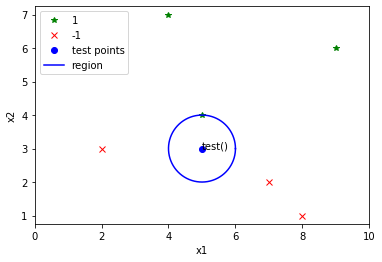

k=3,被分类为： -1


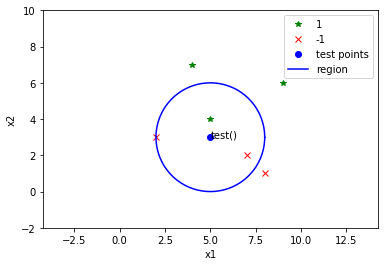

k=5,被分类为： -1


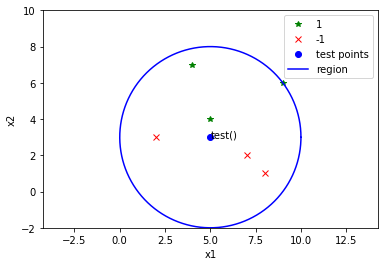

In [6]:
if __name__ == "__main__":
    main1()

## 4. 上面算法存在的问题分析：
> 1. X_new 每次只能处理一个点，没法处理多个。<br>
> &nbsp;&nbsp;解决： 想处理多个点：
>> （1）可以用for循环的方式， 但是如果数据太多的话<br>（2）我们还想用多进程的方式，把CPU的资源利用起来
>
>2. dist_list.sort(key=lambda x: x[0])  这个是全把距离给存到距离列表中，然后再排序，取出前k个最小值，这样浪费空间和时间<br>
>&nbsp;&nbsp;解决：
>> 我们用堆这个数据结构，我们建一个k个空间的堆，然后对其排序， 这样可以减少空间和时间


## 5. 改进的线性扫描算法
> 改进点：
><br> 1. 采用了堆的数据结构<br> 2. 采用了多进程实现

### 5.1 定义改进的线性扫描算法的类和对象


In [7]:
class KNN_improve:
    
    # 初始化成员
    def __init__(self, X_train, Y_train, k=3):
        self.k = k
        self.X_train = X_train
        self.Y_train = Y_train
    
    
    def predict_single(self, X_new):
        # 计算与前k个样本点欧氏距离， 距离取负值是把问题转为取前K个最大的距离
        dist_list=[(-np.linalg.norm(X_new-self.X_train[i],ord=2),self.Y_train[i],i)
                   for i in range(self.k)]
        
        # 利用前k个距离构建堆
        heapq.heapify(dist_list)
        
        # 遍历计算与剩下样本点的欧式距离
        for i in range (self.k, self.X_train.shape[0]):
            dist_i=(-np.linalg.norm(X_new-self.X_train[i],ord=2),self.Y_train[i],i)
            # 若dist_i 比dist_list的最小值大， 则用dist_i替换该最小值，执行下堆操作
            if dist_i[0] > dist_list[0][0]:
                heapq.heappushpop(dist_list, dist_i)
            # 若dist_i 比 dist_list的最小值小，堆保持不变 继续遍历
            else:
                continue
        
        y_list=[dist_list[i][1] for i in range(self.k)] 
        #[-1,1,1,-1...]
        # 对上述k个点的分类进行统计
        y_count=Counter(y_list).most_common()
        #{1:n,-1:m}
        return y_count[0][0]
    
    # 基于for循环处理多个例子吧
    def predict_many(self, X_new):
        res = []
        for i in range(X_new.shape[0]):
            res.append(self.predict_single(X_new[i]))
            
        return res
                
    # 用多进程实现并行， 处理多个值的搜索   但是不知道什么 原因，在Windows运行多进程会报错 
    #BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

#     def predict_many(self,X_new):
#         # 导入多进程
#         with futures.ProcessPoolExecutor(max_workers=4) as executor:
#             # 建立多进程任务
#             tasks=[executor.submit(self.predict_single,X_new[i]) for i in range(X_new.shape[0])]
#             # 驱动多进程运行
#             done_iter=futures.as_completed(tasks)
#             # 提取运行结果
#             res=[future.result() for future in done_iter]
#         return res

### 5.2 主函数

In [8]:
def main():
    t0 = time.time()

    # 构造数据集
    X_train = np.array([[5, 4], [9, 6], [4, 7], [2, 3], [8, 1], [7, 2]])
    Y_train = np.array([1, 1, 1, -1, -1, -1])

    # 测试数据
    X_test = np.array([[5, 3], [9, 2]])

    # 不同的k（取奇数）对分类结果的影响
    for k in range(1, 6, 2):
        # 构建KNN实例
        clf = KNN_improve(X_train, Y_train, k=k)
    
        # 对测试集进行预测
        y_predict = clf.predict_many(X_test)
        print("k = ", k)
        for i in range(X_test.shape[0]):
            print(X_test[i], "被分类为：", y_predict[i])
        
        # 绘图
        visual_result(X_train, Y_train, X_test, k, True)
        print()

    print("用时： {} s".format(round(time.time()-t0), 2))

k =  1
[5 3] 被分类为： 1
[9 2] 被分类为： -1


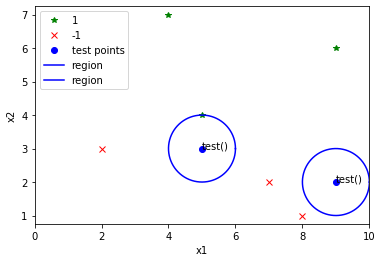


k =  3
[5 3] 被分类为： -1
[9 2] 被分类为： -1


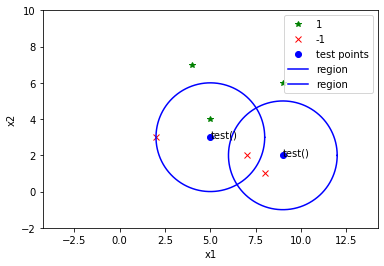


k =  5
[5 3] 被分类为： -1
[9 2] 被分类为： 1


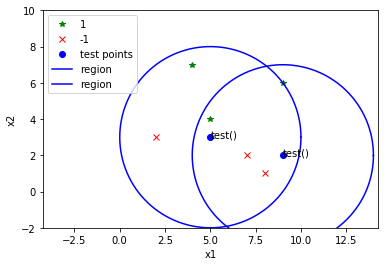


用时： 0 s


In [9]:
if __name__ == "__main__":
    main()

## 6. kd树算法
> kd树主要分为两块： 构建kd树和kd树搜索

### 6.1 定义kd树算法类和对象

In [20]:
# 建立节点类
class Node(namedtuple("Node", "location left_child right_child")):
    def __repr__(self):
        return str(tuple(self))

# kd tree 类
class KdTree:
    
    # 参数成员初始化
    def __init(self, k=1, p=2):
        self.k = k
        self.p = p
        self.kdtree = None
    
    # 构建kd tree
    def _fit(self, X, depth=0):
        try:
            k = X.shape[1]
        except IndexError as e:
            return None
        
        # 选择维度
        axis = depth % k
        X = X[X[:, axis].argsort()]
        median = X.shape[0] // 2
        try:
            X[median]
        except IndexError:
            return None
        return Node(
            location = X[median],
            left_child = self._fit(X[:median], depth+1),
            right_child = self._fit(X[median+1:], depth+1)
        )
        
    # 搜索
    def _search(self, point, tree=None, depth=0, best=None):
        if tree is None:
            return best
        k = point.shape[1]
            
        # 更新branch
        if point[0][depth%k] < tree.location[depth%k]:
            next_branch = tree.left_child
        else:
            next_branch = tree.right_child
            
        if not next_branch is None:
            best = next_branch.location
            
        return self._search(point, tree=next_branch, depth=depth+1, best=best)
       
    def fit(self, X):
        self.kdtree = self._fit(X)
        return self.kdtree

    def predict(self, X):
        res = self._search(X, self.kdtree)
        return res

### 6.2 主函数

In [33]:
def main():
    KNN=KdTree()
    X_train=np.array([[5,4],
                      [9,6],
                      [4,7],
                      [2,3],
                      [8,1],
                      [7,2]])
    Y_train=np.array([1,1,1,-1,-1,-1])
    KNN.fit(X_train)
    X_new=np.array([[6,2]])
    
    visual_result(X_train, Y_train, X_new, 1, True)
    res=KNN.predict(X_new)
    print(res)

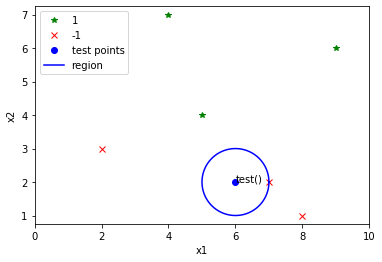

[2 3]


In [34]:
if __name__=="__main__":
    main()

## 7. 总结回顾
> 这次编程主要实现了KNN分类算法： 线性扫描法为主， kd树法为辅
> 1. 线性扫描算法中， 总体思想就是： 计算出训练集中所有的点与测试点之间的距离，然后排序，把前k个小的取出来，分析里面的多数类标签，然后预测成这个标签<br>
>2. 改进的线性扫描算法思想一样，但是可以预测多个测试样本， 并且使用堆的结构进行存放数据，节约了空间和时间<br>
> 3. 关于kd树， 要知道原理， 代码有点复杂，并且最终结果也不是那么好

> 学习到Python和Numpy的几个模块：
>1. python 的time模块
>> time.time()  获取一个时间戳， 一个偏移量， 程序运行之前调用一下，程序运行完之后调用一下，两个相减，就可以得到程序运行所用时间<br>
PS: 关于time模块详见： http://note.youdao.com/noteshare?id=7313fc184d2723ca7dd36060cfa079f1&sub=491CA425B9514634A5FB0ACAA6D43F79
>2. collections模块
>> 该模块里面有几个比较好用的类， Counter计数 namedtuple 使用名字访问元祖中的元素 OrderedDict 有序字典等<br>
PS: 关于collections模块： http://note.youdao.com/noteshare?id=09fc78c3482fbf65267a970fbd8f1f04&sub=A7D08F27C5714705802DF4032D3C8447
>3. heapq模块
>> 提供了堆排序算法的实现  创建堆，访问堆内容等<br>
PS: heapq模块：http://note.youdao.com/noteshare?id=5f741b556c05d308bcd5c420dfb2afe5&sub=54EEEA0F81EB45F088737B9DF45B162C
>4. linalg模块
>> 用到了里面的求解范数的方法norm。 计算距离的二范数。 这是个线性代数模块， 使用这个模块还可以求逆矩阵， 特征值，线性方程组， 行列式等<br>
PS:  linalg模块: http://note.youdao.com/noteshare?id=ed96866b5d213591e2210ada362af055&sub=FFE3C30E80674FBE86D0134E4544521C
>

> 学习到Python的列表排序方法 [.sort(), sorted(), argsort()函数](http://note.youdao.com/noteshare?id=a654a816d2ef43fd3f913e70a49465a3&sub=825DDE48CD414B52B54135CDE0A4AB80)<br>
> 学习到Python的序列解包 [ for x, y in zip(list1, list2)](http://note.youdao.com/noteshare?id=1f348347f700f46eed57adcfca2d421e&sub=13FFAB48B62C480FACB418F31C2678DE)<br>
> 学习到Python输出格式化方法 [format()](http://note.youdao.com/noteshare?id=33c4fc1100be01373cebec07d9204370&sub=D1EAD8C83B0545E8B8D6E7593CFCA1D9)

In [35]:
list_1 = [1, 2, 3, 4]
list_2 = ['a', 'b', 'c']
 
for x, y in zip(list_1, list_2):
    print(x, y)

1 a
2 b
3 c
